In [1]:
!pip install -U transformers accelerate bitsandbytes unsloth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.1/381.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 872.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2

In [2]:
import torch
from transformers import AutoProcessor
from unsloth import FastVisionModel
from PIL import Image
import requests
from io import BytesIO

assert torch.cuda.is_available()
print("GPU:", torch.cuda.get_device_name(0))


/tmp/ipython-input-2567040621.py:3: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastVisionModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
GPU: Tesla T4


Saving Golden-Retriever-1024x683.jpg to Golden-Retriever-1024x683.jpg


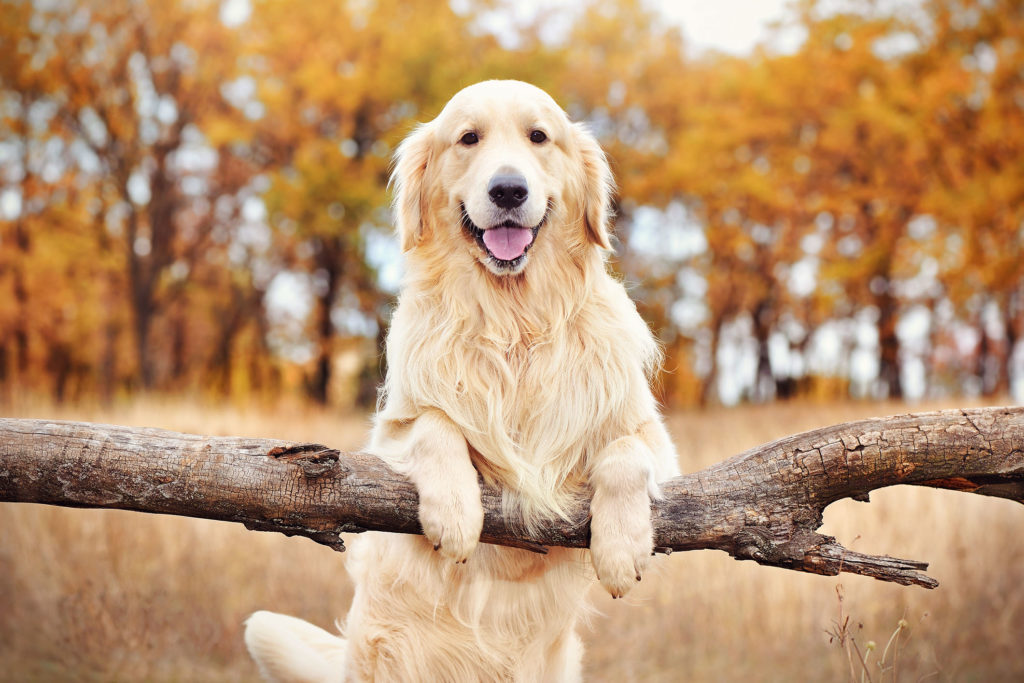

In [4]:
from google.colab import files
uploaded = files.upload()

from PIL import Image

image = Image.open(list(uploaded.keys())[0]).convert("RGB")
display(image)


In [5]:
MODEL = "Qwen/Qwen2.5-VL-7B-Instruct"

model, tokenizer = FastVisionModel.from_pretrained(
    MODEL,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

print("✅ Model loaded")


==((====))==  Unsloth 2026.1.2: Fast Qwen2_5_Vl patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.90G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

✅ Model loaded


In [17]:
long_text = (
    "Describe the image in detail. "
    "Focus on objects, background, actions, colors, and context. "
    "Explain what might be happening and possible interpretations. "
)   # deliberately long


In [35]:
def count_tokens(max_len):
    processor = AutoProcessor.from_pretrained(MODEL)

    messages = [{
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": long_text}
        ]
    }]

    text = processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = processor(
        images=[image],
        text=[text],
        return_tensors="pt",
        truncation=False,
        max_length=max_len
    )

    return {
        "max_length": max_len,
        "total_tokens": inputs["input_ids"].shape[1]
    }


In [40]:
result_512 = count_tokens(512)
result_1024 = count_tokens(1024)

result_512, result_1024


({'max_length': 512, 'total_tokens': 938},
 {'max_length': 1024, 'total_tokens': 938})

### ✅ Sequence Length Impact

This experiment demonstrates that image tokens occupy a fixed portion of the
context window in Qwen-VL. When `max_seq_length` is too small, truncation
breaks alignment between image tokens and text, resulting in hard failures.

This confirms that sequence length is a critical hyperparameter for
vision–language models, unlike text-only LLMs, and must be increased to
preserve usable text context.
